# Steps
1. Overall accuracy comparison, F1, precision, recall analysis.
2. Confusion matrices (for each model).
3. Where BERT is correct but climateBERT is wrong.
4. Where climateBERT is correct but BERT is wrong.
6. Model agreement (both correct or both wrong)


# Imports and Data

In [49]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import re
import pandas as pd
from sklearn.metrics import classification_report, f1_score

In [50]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [51]:
test_data_numeric = pd.read_csv('/content/drive/MyDrive/w266/Final Project/test_data.csv', sep=',')
BERT_results = pd.read_csv('/content/drive/MyDrive/w266/Final Project/meral_results/BERT_test_results.csv', sep=',')
climateBERT_results = pd.read_csv('/content/drive/MyDrive/w266/Final Project/meral_results/climateBERT_test_results.csv', sep=',')

In [52]:
test_data_numeric.head()

,Sentence,Sentiment
0,Evidence now leans against global warming resu...,1
1,45 % of the general public view perceived glob...,0
2,There is a danger that we can get used to glob...,2
3,Global warming isn’t happening.,1
4,Humans have a role and therefore as a matter o...,2


In [53]:
BERT_results.head()

,Predictions
0,1
1,0
2,2
3,1
4,0


In [54]:
climateBERT_results.head()

,Predictions
0,0
1,0
2,2
3,1
4,2


In [55]:
# Label mapping for replacing numeric labels with text
label_mapping = {0: 'Neutral', 1: 'Disagree', 2: 'Agree'}
test_data = test_data_numeric.copy()

# Replace numeric labels
test_data['Sentiment'] = test_data['Sentiment'].replace(label_mapping)
BERT_results['Predictions'] = BERT_results['Predictions'].replace(label_mapping)
climateBERT_results['Predictions'] = climateBERT_results['Predictions'].replace(label_mapping)

# Join three dfs
results = pd.concat([test_data, BERT_results, climateBERT_results], axis=1)
results.columns = ['Sentence', 'True Label', 'BERT', 'climateBERT']
results.head()

,Sentence,True Label,BERT,climateBERT
0,Evidence now leans against global warming resu...,Disagree,Disagree,Neutral
1,45 % of the general public view perceived glob...,Neutral,Neutral,Neutral
2,There is a danger that we can get used to glob...,Agree,Agree,Agree
3,Global warming isn’t happening.,Disagree,Disagree,Disagree
4,Humans have a role and therefore as a matter o...,Agree,Neutral,Agree


# 1. Accuracy, Precision, Recall, F1 Analysis

In [56]:
print("Majority Class Baseline Accuracy: 0.32") # from meral_baseline_and_BERT.ipnyb, Majority Class Baseline
print("BERT Accuracy: ", (results['True Label'] == results['BERT']).mean())
print("climateBERT Accuracy: ", (results['True Label'] == results['climateBERT']).mean())

Majority Class Baseline Accuracy: 0.32
BERT Accuracy:  0.62
climateBERT Accuracy:  0.72


In [57]:
# Baseline F1 score

true_labels = np.array(test_data_numeric['Sentiment'])

# Majority class classifier always predicts 2
majority_predictions = np.full_like(true_labels, fill_value=2)

# Calculate F1 score
wf1 = f1_score(true_labels, majority_predictions, average='weighted')
mf1 = f1_score(true_labels, majority_predictions, average='macro')
print("Weighted Score:", round(wf1,2))
print("Macro Score:", round(mf1,2))

Weighted Score: 0.21
Macro Score: 0.18


In [58]:
b_classification_report = classification_report(results['True Label'], results['BERT'])
cb_classification_report = classification_report(results['True Label'], results['climateBERT'])

print("BERT Classification Report:\n", b_classification_report)
print("\nclimateBERT Classification Report:\n", cb_classification_report)


BERT Classification Report:
               precision    recall  f1-score   support

       Agree       0.81      0.38      0.52        76
    Disagree       0.47      0.87      0.61        39
     Neutral       0.66      0.72      0.69        85

    accuracy                           0.62       200
   macro avg       0.65      0.66      0.61       200
weighted avg       0.68      0.62      0.61       200


climateBERT Classification Report:
               precision    recall  f1-score   support

       Agree       0.82      0.67      0.74        76
    Disagree       0.71      0.62      0.66        39
     Neutral       0.66      0.81      0.73        85

    accuracy                           0.72       200
   macro avg       0.73      0.70      0.71       200
weighted avg       0.73      0.72      0.72       200



ClimateBERT had a 10% higher accuracy than BERT. It also has a 11% higher weighted average F1 score. The accuracy of a majority class classifier is 32% (see meral_baseline_and_BERT.ipnyb, Majority Class Baseline).

While all of the categories have lower F1 scores for BERT over climateBERT, BERT's lowest F1 is Agree while climateBERT's is Disagree. This is interesting because disagree has the lowest support, so having a lower agree F1 score isn't from a class imbalance in the dataset.

# 2. Confusion Matrices

Takeaway:
* ClimateBERT was much better predicting all classes. It was better at predicting neutral that BERT (recall), but it was worse at predicting disagree (recall).

In [59]:
from sklearn.metrics import confusion_matrix

# Create confusion matrix heatmap
def create_confusion_matrix(y_true, y_pred, title, vmax=None):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=['Neutral', 'Disagree', 'Agree'],
                yticklabels=['Neutral', 'Disagree', 'Agree'],
                ax=ax, vmin=0, vmax=vmax)
    ax.set_title(title)
    ax.set_xlabel("Predicted Labels")
    ax.set_ylabel("True Labels")
    plt.close()
    return fig

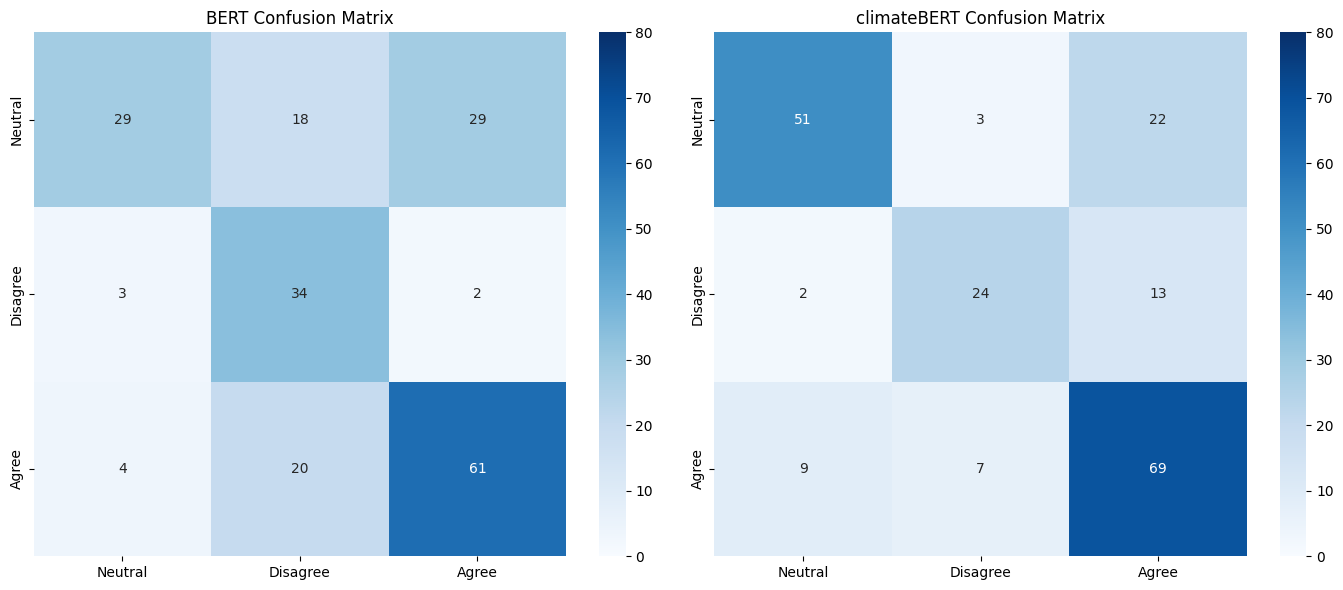

In [60]:
# Create CMs for BERT and climateBERT
b_cm_figure = create_confusion_matrix(results['True Label'], results['BERT'], "BERT Confusion Matrix")
cb_cm_figure = create_confusion_matrix(results['True Label'], results['climateBERT'], "climateBERT Confusion Matrix")

fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # Adjusted size for 1x2 layout

# Plot CMS
sns.heatmap(confusion_matrix(results['True Label'], results['BERT']), annot=True, fmt="d", cmap="Blues",
            xticklabels=['Neutral', 'Disagree', 'Agree'], yticklabels=['Neutral', 'Disagree', 'Agree'], ax=axes[0], vmin=0, vmax=80)
sns.heatmap(confusion_matrix(results['True Label'], results['climateBERT']), annot=True, fmt="d", cmap="Blues",
            xticklabels=['Neutral', 'Disagree', 'Agree'], yticklabels=['Neutral', 'Disagree', 'Agree'], ax=axes[1], vmin=0, vmax=80)

# Set titles
axes[0].set_title("BERT Confusion Matrix")
axes[1].set_title("climateBERT Confusion Matrix")

# Remove axis labels from the subplots
for ax in axes:
    ax.set_ylabel('')
    ax.set_xlabel('')

# Adjust layout for better spacing
plt.tight_layout()

plt.show()

ClimateBERT was much better predicting all classes. It was better at predicting neutral that BERT, but it was worse at predicting disagree.

# 3. Where BERT is correct but climateBERT is wrong

Takeaway:
* ClimateBERT is mostly erring to BERT when it's a disagree. ClimateBERT erroneously says they're neutral statements.
* Out of all sentences with quotes, climateBERT only got the sentence that used quotes sarcastically incorrect. There was only one instance of this so we should look at this in future steps.

In [61]:
# Find where BERT was correct but climateBERT was wrong
b_better = results[(results['True Label'] == results['BERT']) & (results['True Label'] != results['climateBERT'])]
b_better[['Sentence','True Label','climateBERT']].sort_values(by='True Label')

,Sentence,True Label,climateBERT
10,If the media put global warming front and cent...,Agree,Neutral
37,The Houston storm surge is half a foot higher ...,Agree,Neutral
146,The main responsibility to cut emissions lies ...,Agree,Neutral
0,Evidence now leans against global warming resu...,Disagree,Neutral
154,But the erosion of science reaches well beyond...,Disagree,Neutral
149,Recent hurricane activity had not been made mo...,Disagree,Neutral
135,This is especially true of the fossil fuel whi...,Disagree,Neutral
188,Recent fires are partly a product of condition...,Disagree,Neutral
116,When liberals talk about the dire threat of gl...,Disagree,Neutral
68,Satellite data disputes global warming.,Disagree,Neutral


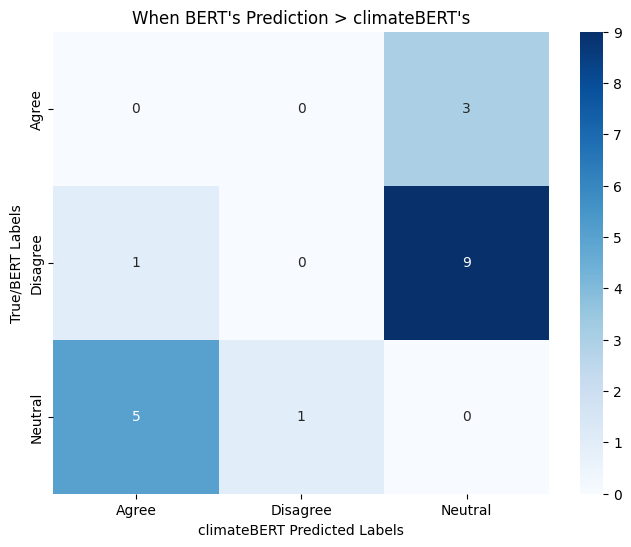

In [62]:
# Make confusion matrix
cm = confusion_matrix(b_better['True Label'], b_better['climateBERT'])

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Agree', 'Disagree', 'Neutral'], yticklabels=['Agree', 'Disagree', 'Neutral'])

# Titles and labels
plt.title('When BERT\'s Prediction > climateBERT\'s')
plt.xlabel('climateBERT Predicted Labels')
plt.ylabel('True/BERT Labels')

plt.show()

ClimateBERT is mostly erring to BERT when it's a disagree. ClimateBERT erroneously says they're neutral statements.

In [63]:
b_better[['Sentence','climateBERT']][b_better['BERT'] == 'Disagree'].sort_values(by='climateBERT')

,Sentence,climateBERT
30,The fifteen-year long “ global warming ” campa...,Agree
0,Evidence now leans against global warming resu...,Neutral
63,The global climate is at the tail end of a dec...,Neutral
68,Satellite data disputes global warming.,Neutral
116,When liberals talk about the dire threat of gl...,Neutral
135,This is especially true of the fossil fuel whi...,Neutral
149,Recent hurricane activity had not been made mo...,Neutral
154,But the erosion of science reaches well beyond...,Neutral
188,Recent fires are partly a product of condition...,Neutral
197,American diplomacy can convince the communist ...,Neutral


Looking at the when the true label = BERT = Disagree on the sentence level, we see that the agree sentence is very long. It also was said with sarcasm using air quotes. I wonder if BERT was better at detecting sarcasm. I want to pull every sentence with quotes and see which model did better.

In [64]:
quote_df = results[results['Sentence'].str.contains(r"[\"“”]", na=False)]
b_quote_df = quote_df[(quote_df['BERT'] == quote_df['True Label']) & (quote_df['climateBERT'] != quote_df['True Label'])]
cb_quote_df = quote_df[(quote_df['climateBERT'] == quote_df['True Label']) & (quote_df['BERT'] != quote_df['True Label'])]
same_quote_df = quote_df[(quote_df['BERT'] == quote_df['True Label']) & (quote_df['climateBERT'] == quote_df['True Label'])]
none_quote_df = quote_df[(quote_df['BERT'] != quote_df['True Label']) & (quote_df['climateBERT'] != quote_df['True Label'])]

In [65]:
print("BERT quotes: ",b_quote_df.Sentence.count())
print("climateBERT quotes: ",cb_quote_df.Sentence.count())
print("All Accurate quotes: ",same_quote_df.Sentence.count())
print("None Accurate quotes: ",none_quote_df.Sentence.count())

BERT quotes:  1
climateBERT quotes:  2
All Accurate quotes:  5
None Accurate quotes:  0


In [66]:
quote_df

,Sentence,True Label,BERT,climateBERT
30,The fifteen-year long “ global warming ” campa...,Disagree,Disagree,Agree
36,Antarctica glacier could collapse within decad...,Neutral,Agree,Neutral
75,Development of oil and gas resources in the Ar...,Neutral,Disagree,Neutral
81,Hundreds of government scientists have perceiv...,Neutral,Neutral,Neutral
84,"Pruitt didn't believe carbon dioxide is a ""pri...",Neutral,Neutral,Neutral
87,"This, as those familiar with the Climategate a...",Disagree,Disagree,Disagree
110,Science doesn't know how bad the greenhouse ef...,Disagree,Disagree,Disagree
191,"224 of the 386 ""climate change contrarians"" qu...",Neutral,Neutral,Neutral


Interestingly, it seems that climateBERT only got the sentence that used quotes sarcastically incorrect. There was only one instance of this so we should look at this in future steps.

In [67]:
# b better average sentence length
print("b better average sentence length: ", round(b_better['Sentence'].str.len().mean(), 2))
print("cb better average sentence length: ", round(results['Sentence'][(results['True Label'] != results['BERT']) & (results['True Label'] == results['climateBERT'])].str.len().mean(),2))
print("average sentence length for all results: ", round(results['Sentence'].str.len().mean(),2))

b better average sentence length:  119.53
cb better average sentence length:  124.36
average sentence length for all results:  115.6


Doesn't seem like b_better had longer sentences than cb_better, but both are bigger than the average sentence length.

# 4. Where ClimateBERT is correct and BERT is wrong

Takeaways:
* BERT is mostly confusing agrees with disagrees and neutrals. It is probably overpredicting disagree/neutral. Maybe the class imbalance has bee overcorrected?
* When BERT predicted disagree even though the true answer was agree, often have domaign-specific facts in them (annecdotal).


In [68]:
cb_better = results[(results['True Label'] != results['BERT']) & (results['True Label'] == results['climateBERT'])]
cb_better

,Sentence,True Label,BERT,climateBERT
4,Humans have a role and therefore as a matter o...,Agree,Neutral,Agree
12,And that’s not the only way global warming cau...,Agree,Disagree,Agree
32,"By the year 2100, floods like the ones caused ...",Agree,Neutral,Agree
34,"In other words, to the extent the public belie...",Neutral,Disagree,Neutral
36,Antarctica glacier could collapse within decad...,Neutral,Agree,Neutral
40,"The Arctic ice cap, which is thought to have l...",Agree,Neutral,Agree
45,Gas prices will not drop significantly because...,Neutral,Disagree,Neutral
47,The Arctic’s albedo may be declining much fast...,Neutral,Disagree,Neutral
51,It is too simplistic in its analysis of carbon...,Neutral,Disagree,Neutral
60,I am a firm believer that climate change is re...,Agree,Neutral,Agree


In [69]:
# Get value counts for each DataFrame's 'True Label' column
cb_value_counts = cb_better['True Label'].value_counts()
b_value_counts = b_better['True Label'].value_counts()

# Concatenate the two value counts horizontally and replace NaN with 0
pd.concat([cb_value_counts, b_value_counts], axis=1, keys=['cb_better', 'b_better']).fillna(0).sort_values(by='True Label', ascending=True)

,cb_better,b_better
True Label,,
Agree,25.0,3
Disagree,0.0,10
Neutral,14.0,6


It looks like BERT was better at analysing when the answer was disagree than ClimateBERT. It looks like ClimateBERT was better overall, especially at discovering agrees.

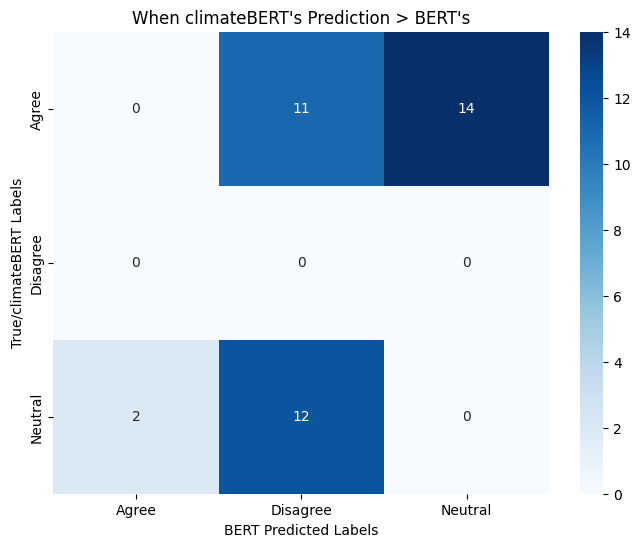

In [70]:
# Make confusion matrix
cm = confusion_matrix(cb_better['True Label'], cb_better['BERT'])

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Agree', 'Disagree', 'Neutral'], yticklabels=['Agree', 'Disagree', 'Neutral'])

# Titles and labels
plt.title('When climateBERT\'s Prediction > BERT\'s')
plt.xlabel('BERT Predicted Labels')
plt.ylabel('True/climateBERT Labels')

plt.show()

BERT is mostly confusing agrees with disagrees and neutrals. It is probably overpredicting disagree/neutral. Maybe the class imbalance has bee overcorrected?

In [71]:
# look at when True = Agree but BERT = Disagree
cb_better[['Sentence']][(cb_better['BERT']=='Disagree') & (cb_better['True Label']=='Agree')]

,Sentence
12,And that’s not the only way global warming cau...
95,"Unfortunately, what is happening now in our ce..."
100,The rate at which they are diminishing is more...
101,The scale of emission reductions necessary to ...
120,"And ocean acidification, which comes from the ..."
141,Global warming is a âmeteorâ that will â...
159,Everyone is responsible for trying to reduce c...
166,"Climate change is not a hoax, but climate chan..."
169,It's unquestionable that this year's Kincade f...
182,Democrats and Republicans are not acting more ...


When BERT predicted disagree even though the true answer was agree, often have domaign-specific facts in them (101, 120, 159).

It seems like 166 should have been an easy Agree but I'm not sure why BERT isn't seeing that.

In [72]:
# look at when True = Agree but BERT = Neutral
cb_better[['Sentence']][(cb_better['BERT']=='Neutral') & (cb_better['True Label']=='Agree')]

,Sentence
4,Humans have a role and therefore as a matter o...
32,"By the year 2100, floods like the ones caused ..."
40,"The Arctic ice cap, which is thought to have l..."
60,I am a firm believer that climate change is re...
76,A warning sign that some scientists worry coul...
96,Radical innovation in low-carbon energy techno...
104,Existing national pledges to restrict greenhou...
122,Even if countries slammed the brakes on emissi...
129,The combination of the warm ocean and the effe...
132,Doing something about climate change is loving...


Some of these also have more domaign-specific facts (eg. 194, 122, 129, etc.) However, a lot of these seem like easily categorizable sentences.

# 5. Model Agreement

Takeaways:
* When both models were wrong, they were most often marking agree sentences as neutral.
* Wrong sentences seem to be shorter but there is no statistically significant difference in sentence lengths.
* Models were mostly able to reach consensus about neutral sentences. This is interesting because most sentences are Agree.
* Sentences that all models got correct were average length

## Find where models agree and are wrong


In [73]:
# find where models agree and are wrong

wrong_agree_df = results[(results['BERT'] == results['climateBERT']) & (results['BERT'] != results['True Label'])]
wrong_agree_df.head()

,Sentence,True Label,BERT,climateBERT
9,Global warming is not expected to end anytime ...,Agree,Disagree,Disagree
13,The globally averaged sea surface temperature ...,Agree,Neutral,Neutral
14,Global temperatures in 2014 shattered earlier ...,Agree,Neutral,Neutral
19,The findings do not undermine global warming t...,Neutral,Disagree,Disagree
20,After the most extensive and expensive global ...,Disagree,Neutral,Neutral


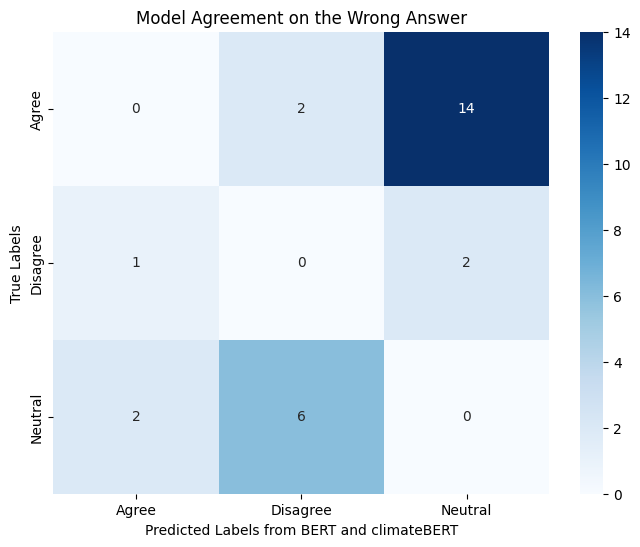

In [74]:
# Extract true labels and predictions
true_labels = wrong_agree_df['True Label']
predictions = wrong_agree_df['BERT']

cm = confusion_matrix(true_labels, predictions)

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Agree', 'Disagree', 'Neutral'],
            yticklabels=['Agree', 'Disagree', 'Neutral'])

# Add labels and title
plt.title("Model Agreement on the Wrong Answer")
plt.xlabel("Predicted Labels from BERT and climateBERT")
plt.ylabel("True Labels")

plt.show()

When both models were wrong, they were most often marking agree sentences as neutral. Let's look at these sentences

In [75]:
wrong_agree_df[["Sentence"]][(wrong_agree_df["True Label"] == "Agree") & (wrong_agree_df["BERT"] == "Neutral")]

,Sentence
13,The globally averaged sea surface temperature ...
14,Global temperatures in 2014 shattered earlier ...
29,A United Nations panel is more certain than ev...
33,Sea levels in the Chesapeake Bay are rising at...
44,A majority of respondents believe global warmi...
52,"On the warmest day this month, half the ice sh..."
53,We can expect the Arctic to be ice-free in sum...
153,The Trump administration simply discarded prio...
168,You cannot go too far on the issue of climate ...
170,Protecting still-undamaged forests could have ...


There doesn't seem to be a discernable trend in these sentences other than maybe they're pretty short. Let's see if they're much shorter than average.

In [76]:
print("average sentence length for agree marked as neutral by both models: ",round(wrong_agree_df["Sentence"][(wrong_agree_df["True Label"] == "Agree") & (wrong_agree_df["BERT"] == "Neutral")].str.len().mean(),2))
print("average sentence length for all results: ", round(results['Sentence'].str.len().mean(),2))

average sentence length for agree marked as neutral by both models:  94.5
average sentence length for all results:  115.6


These sentences seem to be shorter than average.

In [77]:
from scipy import stats

# Sentences marked "Neutral" for "Agree" in wrong_agree_df
agree_as_neutral_sentences = wrong_agree_df["Sentence"][(wrong_agree_df["True Label"] == "Agree") & (wrong_agree_df["BERT"] == "Neutral")]

# All sentences in results
all_sentences = results['Sentence']

# Average sentence lengths
agree_as_neutral_length = agree_as_neutral_sentences.str.len()
all_sentences_length = all_sentences.str.len()

# Two-sample t-test
t_stat, p_value = stats.ttest_ind(agree_as_neutral_length, all_sentences_length, nan_policy='omit')

print("T-statistic:", t_stat)
print("P-value:", p_value)

alpha = 0.05  # Significance level (5%)
if p_value < alpha:
    print("There is a statistically significant difference in sentence lengths.")
else:
    print("There is no statistically significant difference in sentence lengths.")


T-statistic: -1.4807551513667918
P-value: 0.14015647690254548
There is no statistically significant difference in sentence lengths.


## Find where models agree and are right


In [78]:
# find where models agree and are right

right_agree_df = results[(results['BERT'] == results['climateBERT']) & (results['BERT'] == results['True Label'])]
right_agree_df.head()

,Sentence,True Label,BERT,climateBERT
1,45 % of the general public view perceived glob...,Neutral,Neutral,Neutral
2,There is a danger that we can get used to glob...,Agree,Agree,Agree
3,Global warming isn’t happening.,Disagree,Disagree,Disagree
5,The global warming has become a new religion.,Disagree,Disagree,Disagree
6,There is no scientific proof that human emissi...,Disagree,Disagree,Disagree


<Axes: xlabel='True Label'>

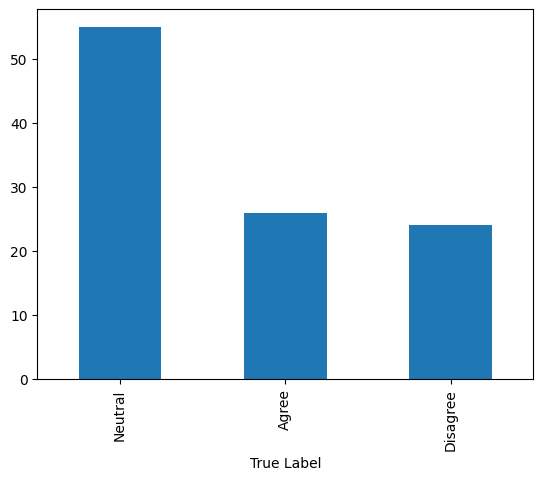

In [79]:
# Extract true labels and predictions
right_agree_df['True Label'].value_counts().plot(kind="bar")

Models were mostly able to reach consensus about neutral sentences. This is interesting because most sentences are Agree.

In [80]:
print("average sentence length for both models correct: ",round(right_agree_df["Sentence"].str.len().mean(),2))
print("average sentence length for all results: ", round(results['Sentence'].str.len().mean(),2))

average sentence length for both models correct:  113.48
average sentence length for all results:  115.6


These sentences seem average length

# Plots

In [81]:
b_classification_report = classification_report(results['True Label'], results['BERT'])
cb_classification_report = classification_report(results['True Label'], results['climateBERT'])

print("BERT Classification Report:\n", b_classification_report)
print("\nclimateBERT Classification Report:\n", cb_classification_report)


BERT Classification Report:
               precision    recall  f1-score   support

       Agree       0.81      0.38      0.52        76
    Disagree       0.47      0.87      0.61        39
     Neutral       0.66      0.72      0.69        85

    accuracy                           0.62       200
   macro avg       0.65      0.66      0.61       200
weighted avg       0.68      0.62      0.61       200


climateBERT Classification Report:
               precision    recall  f1-score   support

       Agree       0.82      0.67      0.74        76
    Disagree       0.71      0.62      0.66        39
     Neutral       0.66      0.81      0.73        85

    accuracy                           0.72       200
   macro avg       0.73      0.70      0.71       200
weighted avg       0.73      0.72      0.72       200



# Where correct=Agree and label=Disagree or vice versa

In [82]:
results[(results['True Label'] == 'Agree') & (results['BERT'] == 'Disagree')]

,Sentence,True Label,BERT,climateBERT
9,Global warming is not expected to end anytime ...,Agree,Disagree,Disagree
11,Progress in avoiding environmental regrets can...,Agree,Disagree,Neutral
12,And that’s not the only way global warming cau...,Agree,Disagree,Agree
71,The hidden health and environmental costs of u...,Agree,Disagree,Neutral
83,Human emissions of greenhouse gasses essential...,Agree,Disagree,Disagree
95,"Unfortunately, what is happening now in our ce...",Agree,Disagree,Agree
100,The rate at which they are diminishing is more...,Agree,Disagree,Agree
101,The scale of emission reductions necessary to ...,Agree,Disagree,Agree
120,"And ocean acidification, which comes from the ...",Agree,Disagree,Agree
141,Global warming is a âmeteorâ that will â...,Agree,Disagree,Agree


In [83]:
results[(results['True Label'] == 'Agree') & (results['climateBERT'] == 'Disagree')]

,Sentence,True Label,BERT,climateBERT
9,Global warming is not expected to end anytime ...,Agree,Disagree,Disagree
83,Human emissions of greenhouse gasses essential...,Agree,Disagree,Disagree
152,There is no point in only reducing greenhouse ...,Agree,Neutral,Disagree


# Are longer sentences more likely to be categorized correctly?

In [84]:
# Get sentence lengths and quantiles
results['Sentence_Length'] = results['Sentence'].str.len()
quantiles = results['Sentence_Length'].quantile([0.25, 0.5, 0.75])

def analyze_performance(df, model_col):
    correct_short = len(df[(df['Sentence_Length'] < quantiles[0.25]) & (df[model_col] == df['True Label'])])
    total_short = len(df[df['Sentence_Length'] < quantiles[0.25]])
    correct_medium = len(df[(df['Sentence_Length'] >= quantiles[0.25]) & (df['Sentence_Length'] < quantiles[0.75]) & (df[model_col] == df['True Label'])])
    total_medium = len(df[(df['Sentence_Length'] >= quantiles[0.25]) & (df['Sentence_Length'] < quantiles[0.75])])
    correct_long = len(df[(df['Sentence_Length'] >= quantiles[0.75]) & (df[model_col] == df['True Label'])])
    total_long = len(df[df['Sentence_Length'] >= quantiles[0.75]])
    print(f"{model_col}:")
    print("Short Sentences (below 0.25 quantile) accuracy:", round(correct_short / total_short, 2) if total_short > 0 else 0 )
    print("Medium Sentences (0.25-0.75 quantiles) accuracy:", round(correct_medium / total_medium, 2) if total_medium > 0 else 0)
    print("Long Sentences (above 0.75 quantile) accuracy:", round(correct_long / total_long, 2) if total_long > 0 else 0)



# BERT
analyze_performance(results, 'BERT')
print()
# ClimateBERT
analyze_performance(results, 'climateBERT')

BERT:
Short Sentences (below 0.25 quantile) accuracy: 0.64
Medium Sentences (0.25-0.75 quantiles) accuracy: 0.62
Long Sentences (above 0.75 quantile) accuracy: 0.6

climateBERT:
Short Sentences (below 0.25 quantile) accuracy: 0.68
Medium Sentences (0.25-0.75 quantiles) accuracy: 0.73
Long Sentences (above 0.75 quantile) accuracy: 0.74


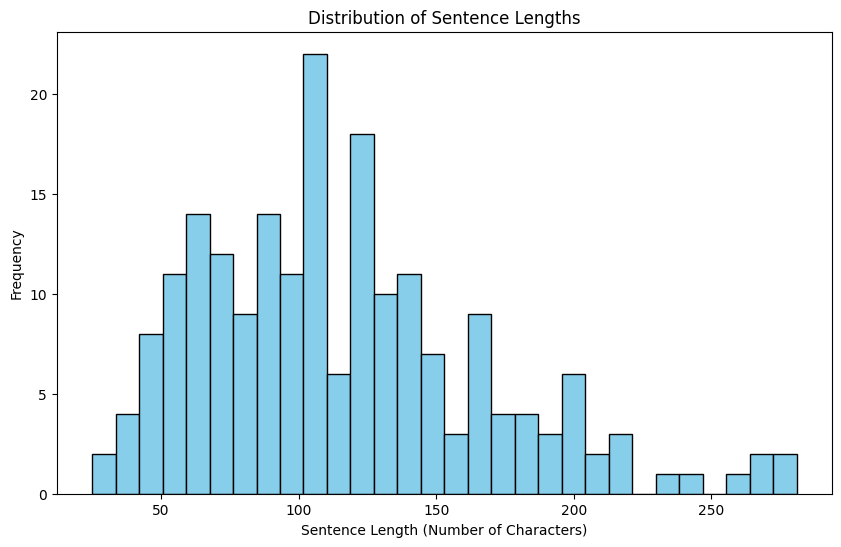

In [85]:
# See sentence length distribution
plt.figure(figsize=(10, 6))
plt.hist(results['Sentence'].str.len(), bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Sentence Lengths')
plt.xlabel('Sentence Length (Number of Characters)')
plt.ylabel('Frequency')
plt.show()

In [87]:
# Find instances where both models incorrectly labeled neutral sentences as agree.
neutral_incorrect_df = results[
    (results["True Label"] == "Neutral")
    & (results["BERT"] == "Agree")
    & (results["climateBERT"] == "Agree")]

neutral_incorrect_df[["Sentence", "True Label", "BERT", "climateBERT"]]

,Sentence,True Label,BERT,climateBERT
24,The Pacific winds are the culprit for slowing ...,Neutral,Agree,Agree
56,Most Caribbean coral reefs will disappear with...,Neutral,Agree,Agree
